In [71]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
import bank_dataset
import importlib
from tqdm.notebook import tqdm
from torchinfo import summary
import math

importlib.reload(bank_dataset)

torch.manual_seed(43);

In [72]:
bank_dataset = bank_dataset.BankDataset("./bank_dataset.csv")
bank_dataset_train, bank_dataset_test = random_split(bank_dataset, [0.8, 0.2])
bank_dataloader_train = DataLoader(bank_dataset_train, batch_size=4, shuffle=True)
bank_dataloader_test = DataLoader(bank_dataset_test, batch_size=1, shuffle=True)

In [73]:
class AttentionHead(nn.Module):
    def __init__(self, embedding_size: int, head_size: int, causal_masking=True):
        super().__init__()
        self.q = nn.Linear(embedding_size, head_size, bias=False)
        self.k = nn.Linear(embedding_size, head_size, bias=False)
        self.v = nn.Linear(embedding_size, head_size, bias=False)
        self.head_size = head_size
        self.causal_masking = causal_masking

    def forward(self, X: Tensor):
        b, c, e = X.shape
        keys: Tensor = self.k(X)
        queries: Tensor = self.q(X)
        values = self.v(X)

        scores = queries.matmul(keys.transpose(-2, -1))
        scores = scores / torch.sqrt(torch.tensor(self.head_size))

        if self.causal_masking:
            mask = torch.tril(torch.ones(c, c))
            mask = mask.masked_fill(mask == 0, float("-inf"))
            scores += mask.unsqueeze(0)

        scores = F.softmax(scores, dim=-1)

        res = scores.matmul(values)

        return res

In [74]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, n_heads, causal_masking):
        super().__init__()
        assert embedding_dim % n_heads == 0

        head_size = embedding_dim // n_heads
        self.ath = nn.ModuleList([AttentionHead(embedding_dim, head_size, causal_masking) for _ in range(n_heads)])
    
    def forward(self, X):
        X = [ath(X) for ath in self.ath]
        X = torch.cat(X, dim=-1)

        return X

In [75]:
class ResidualAdd(nn.Module):
    def __init__(self, inner: nn.Module):
        super().__init__()
        self.inner = inner

    def forward(self, X):
        r = self.inner(X)
        return r+X

In [76]:
class Transformer(nn.Module):
    def __init__(self, embedding_dim, n_heads, causal_masking):
        super().__init__()
        self.layers = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            ResidualAdd(MultiHeadAttention(embedding_dim, n_heads, causal_masking)),
            nn.LayerNorm(embedding_dim),
            ResidualAdd(
                nn.Sequential(
                    nn.Linear(embedding_dim, embedding_dim * 3),
                    nn.ReLU(),
                    nn.Linear(embedding_dim * 3, embedding_dim),
                )
            ),
        )


    def forward(self, X):
        return self.layers(X)

In [77]:
# https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        seq_len = x.size(1)
        x = x + self.pe[:seq_len, :].unsqueeze(0)
        return self.dropout(x)


In [78]:
class BertProMax(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, transformer_count, n_heads, n_classes, positional_encoding, causal_masking):
        super().__init__()
        self.embeddings = nn.Embedding(n_embeddings, embedding_dim)
        if positional_encoding:
            self.positional_encoder = PositionalEncoding(embedding_dim)
        self.positional_encoding = positional_encoding
        self.layers = nn.Sequential(
            *(Transformer(embedding_dim, n_heads, causal_masking) for _ in range(transformer_count)),
            nn.Linear(embedding_dim, n_classes),
        )
        
    def forward(self, X):
        X = self.embeddings(X)
        if self.positional_encoding:
            X = self.positional_encoder(X)
        X = self.layers(X)
        X = X.mean(dim=1)
        return X

In [79]:
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=4,
    transformer_count=1,
    n_heads=2,
    n_classes=3,
    positional_encoding=True,
    causal_masking=True
)

summary(model, input=(26,), dtypes=[torch.int])

Layer (type:depth-idx)                                  Param #
BertProMax                                              --
├─Embedding: 1-1                                        2,604
├─PositionalEncoding: 1-2                               --
│    └─Dropout: 2-1                                     --
├─Sequential: 1-3                                       --
│    └─Transformer: 2-2                                 --
│    │    └─Sequential: 3-1                             176
│    └─Linear: 2-3                                      15
Total params: 2,795
Trainable params: 2,795
Non-trainable params: 0

In [80]:
def train(model: nn.Module, epochs, optimizer, loss_fn):
    losses = []
    for i in tqdm(range(epochs)):
        for x, y in bank_dataloader_train:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            losses.append(loss)
            loss.backward()
            optimizer.step()
    return losses

In [81]:
@torch.no_grad
def eval(index: int):
    x, y = bank_dataset.__getitem__(index)
    y_pred = model(x.unsqueeze(0))
    s = F.softmax(y_pred, dim=-1) 
    highest_class = torch.argmax(s)
    print(bank_dataset.df["Satz"][index])
    print(f"Predicted: {bank_dataset.index2label(highest_class.item())} ({s[0][highest_class].item()*100}%)")
    print(f"True:      {bank_dataset.index2label(y.item())}")

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [82]:
@torch.no_grad
def loss_eval(index: int):
    x, y = bank_dataset.__getitem__(index)
    y_pred = model(x.unsqueeze(0))
    return loss_fn(y_pred, y.unsqueeze(0))

In [83]:
all_losses = torch.tensor([loss_eval(index) for index in range(len(bank_dataset))])

In [84]:
eval(all_losses.argmax().item())

Eine stabile Sitzbank im Park wurde aufgestellt und ist ein Ort zum Nachdenken.
Predicted: Flussbank (51.998722553253174%)
True:      Sitzbank


In [85]:
with torch.no_grad():
    total_val_loss = 0
    for x, y in bank_dataloader_test:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        total_val_loss += loss
    avg_val_loss = total_val_loss / len(bank_dataloader_test)

print(f"Val Loss: {avg_val_loss}")

Val Loss: 1.1751819849014282


In [ ]:
variants = []

loss_fn = nn.CrossEntropyLoss()

# Variant 1: Old model
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=6,
    transformer_count=1,
    n_heads=3,
    n_classes=3,
    positional_encoding=False,
    causal_masking=False
)
optimizer = AdamW(model.parameters())
losses = train(model, 100, optimizer, loss_fn)
variants.append(losses)

# Variant 2: With MMHA
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=6,
    transformer_count=1,
    n_heads=3,
    n_classes=3,
    positional_encoding=False,
    causal_masking=True
)
optimizer = AdamW(model.parameters())
losses = train(model, 100, optimizer, loss_fn)
variants.append(losses)

# Variant 3: With Positional Encoding
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=6,
    transformer_count=1,
    n_heads=3,
    n_classes=3,
    positional_encoding=True,
    causal_masking=False
)
optimizer = AdamW(model.parameters())
losses = train(model, 100, optimizer, loss_fn)
variants.append(losses)

# Variant 4: Multiple Encoder-Cores (Transformer Layers I guess?)
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=6,
    transformer_count=3,
    n_heads=3,
    n_classes=3,
    positional_encoding=False,
    causal_masking=False
)
optimizer = AdamW(model.parameters())
losses = train(model, 100, optimizer, loss_fn)
variants.append(losses)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [89]:
# Variant 5: Everything
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=6,
    transformer_count=3,
    n_heads=3,
    n_classes=3,
    positional_encoding=True,
    causal_masking=True
)
optimizer = AdamW(model.parameters())
losses = train(model, 100, optimizer, loss_fn)
variants.append(losses)

  0%|          | 0/100 [00:00<?, ?it/s]

In [93]:
# Variant 6: Everything big 🔥
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=16,
    transformer_count=8,
    n_heads=4,
    n_classes=3,
    positional_encoding=True,
    causal_masking=True
)
optimizer = AdamW(model.parameters())
losses = train(model, 100, optimizer, loss_fn)
variants.append(losses)

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/ky/4lh6dmdj4wx8v6hjzf8pg82m0000gn/T/ipykernel_93665/2048781404.py:39: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/I568850/repositories/ml-journey/transformers_from_scratch/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


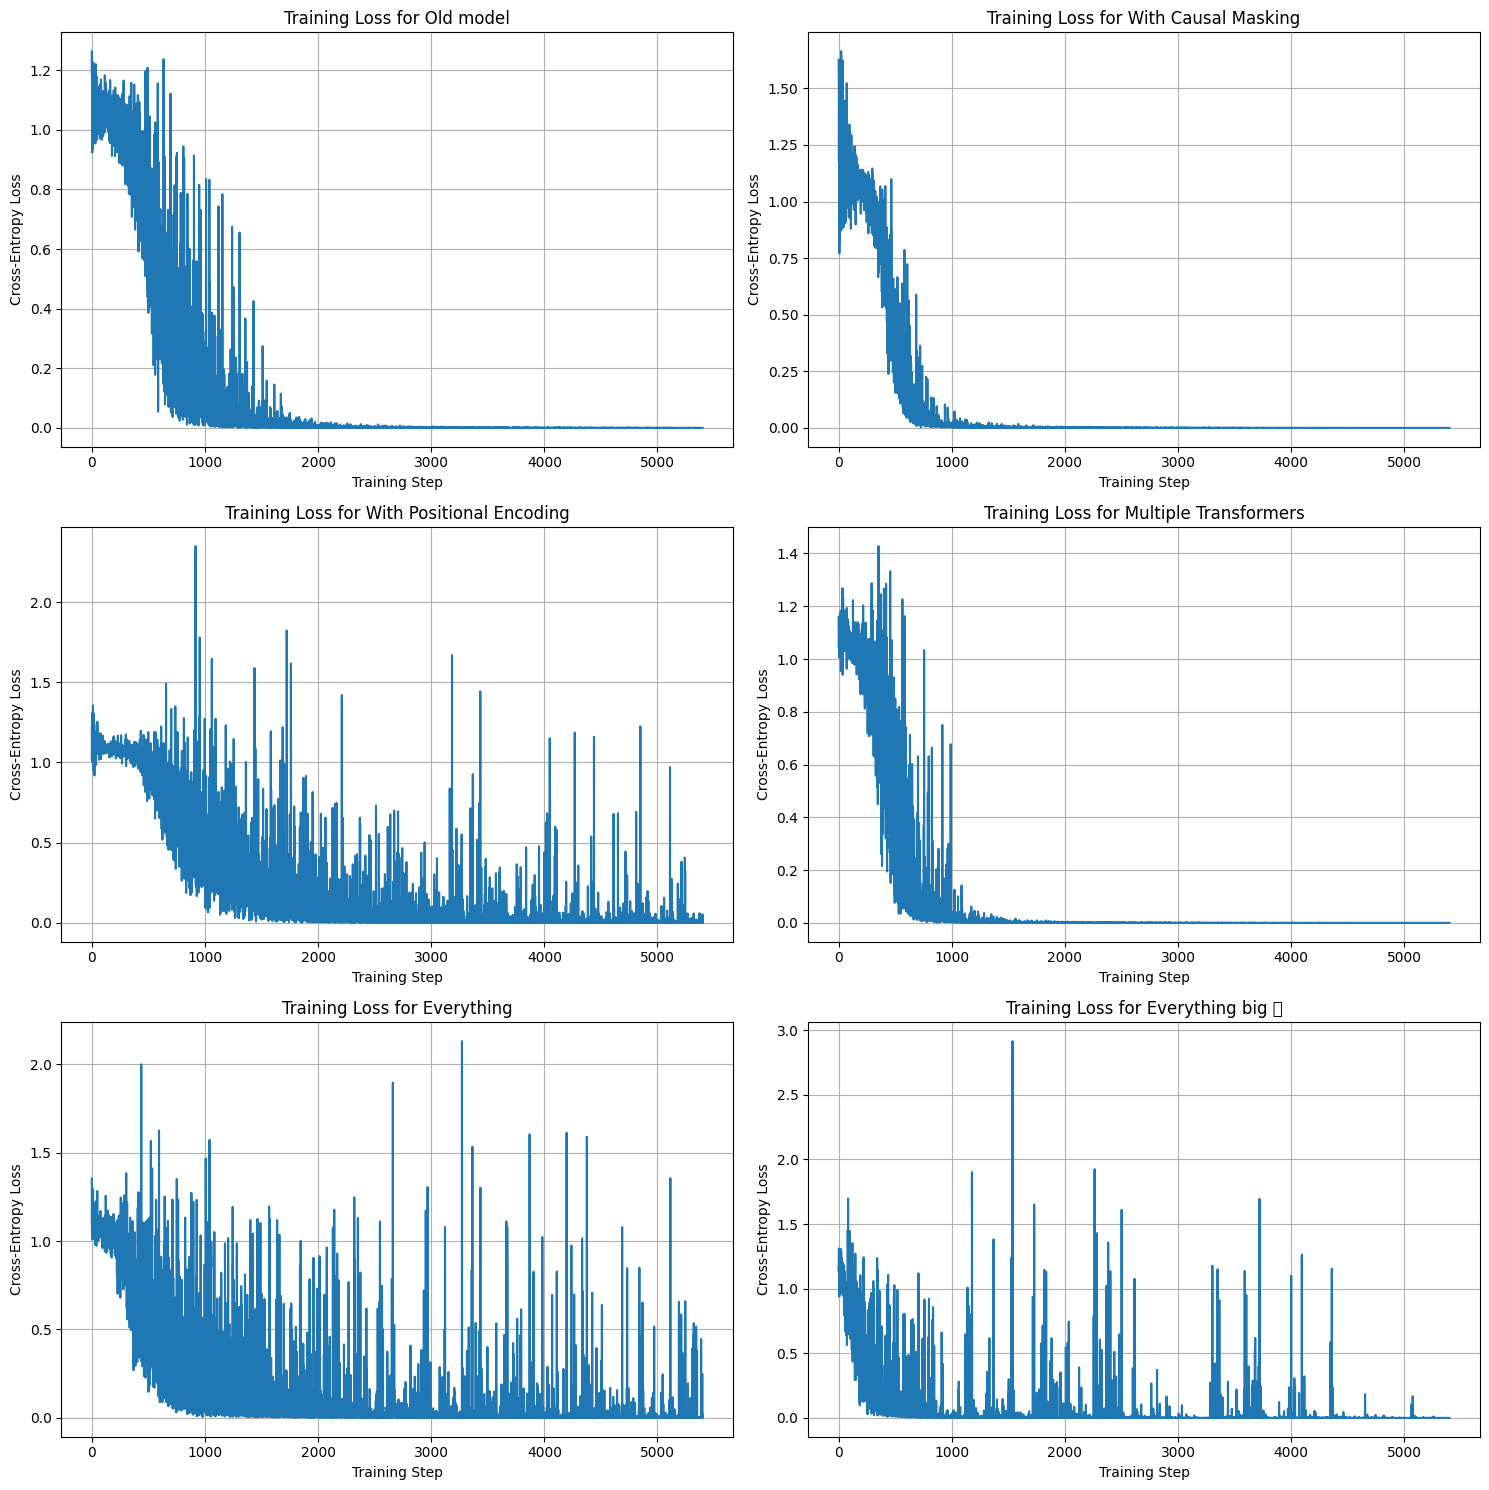

In [94]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

variant_names = [
    "Old model",
    "With Causal Masking",
    "With Positional Encoding",
    "Multiple Transformers",
    "Everything",
    "Everything big 🔥"
]

plot_data = []
for i, variant_losses in enumerate(variants):
    losses_float = [loss.item() for loss in variant_losses]
    
    df_variant = pd.DataFrame({
        'Step': range(len(losses_float)),
        'Loss': losses_float,
        'Variant': variant_names[i]
    })
    plot_data.append(df_variant)

full_plot_data = pd.concat(plot_data)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, variant_name in enumerate(variant_names):
    ax = axes[i]
    variant_data = full_plot_data[full_plot_data['Variant'] == variant_name]
    sns.lineplot(data=variant_data, x='Step', y='Loss', ax=ax)
    ax.set_title(f'Training Loss for {variant_name}')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Cross-Entropy Loss')
    ax.grid(True)

plt.tight_layout()
plt.show()